In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv('./Dataset-p1/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,type
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferate_DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No_DR
4,005b95c28852,0,No_DR


<Axes: ylabel='type'>

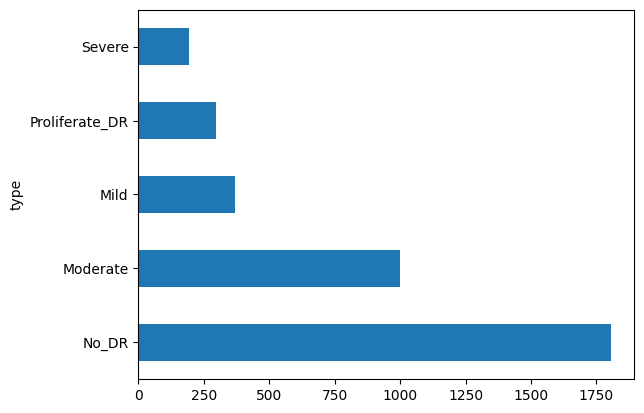

In [3]:
df['type'].value_counts().plot(kind='barh')

In [4]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [5]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [6]:
# Copy images to respective working directory
src_dir = r'./Dataset-p1/train_images'
for index, row in train.iterrows():
    if row['type'] == 'No_DR':
        continue
    else:    
        diagnosis = row['type']
        id_code = row['id_code'] + ".png"
        srcfile = os.path.join(src_dir, id_code)
        dstfile = os.path.join(train_dir, diagnosis)
        os.makedirs(dstfile, exist_ok = True)
        shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    if row['type'] == 'No_DR':
        continue
    else:    
        diagnosis = row['type']
        id_code = row['id_code'] + ".png"
        srcfile = os.path.join(src_dir, id_code)
        dstfile = os.path.join(val_dir, diagnosis)
        os.makedirs(dstfile, exist_ok = True)
        shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    if row['type'] == 'No_DR':
        continue
    else:    
        diagnosis = row['type']
        id_code = row['id_code'] + ".png"
        srcfile = os.path.join(src_dir, id_code)
        dstfile = os.path.join(test_dir, diagnosis)
        os.makedirs(dstfile, exist_ok = True)
        shutil.copy(srcfile, dstfile)


In [7]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 1299 images belonging to 4 classes.
Found 279 images belonging to 4 classes.
Found 279 images belonging to 4 classes.


In [8]:
# Building the model
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam, Nadam, SGD
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model

mob = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in mob.layers:
    layer.trainable = False

x = mob.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=mob.input, outputs=output)

# Compiling the Network
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_batches, epochs=5, validation_data=val_batches)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [9]:
model.save('MobileNet-DR.model')

INFO:tensorflow:Assets written to: MobileNet-DR.model\assets


INFO:tensorflow:Assets written to: MobileNet-DR.model\assets


In [10]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


C:\Users\ASHISH\AppData\Local\Temp\ipykernel_133900\4010420734.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


9/9 [==============================] - 27s 3s/step - loss: 0.9871 - accuracy: 0.6308
Accuracy:  0.6308243870735168
